In [1]:
%cd ../search/search
#! python pacman.py --layout originalClassic

/home/gabriel/Documentos/Tarefas/Universidade/MC886/projects_MachineLearning/project3_ra214129_ra216179/search/search


# Parte II: Reinforcement Learning

Essa parte do projeto tentará resolver o problema do Pacman utilizando o paradigma de Reinforcement Learning por meio do algoritmo de Qlearning

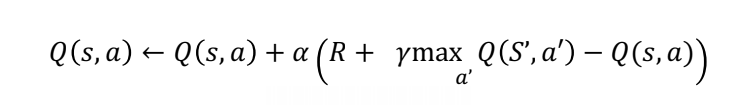  
<b>Imagem 1:</b> Equação Qlearning

O algoritmo Qlearning aprende atualizando a função ação-valor Q por meio dessa equação acima, em que ele atualiza o valor de um estado para a ação que escolhemos comparando com o valor de uma ação alternativa para o próximo estado. Detalharemos como isso está sendo feito a seguir.

%cd ../search/search
#! python pacman.py --layout originalClassic

In [2]:
from pacman import runGames, readCommand
from game import Agent, Directions
from util import manhattanDistance
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [3]:
random.seed(7)

In [4]:
def getState(state):
    currentState = (state.getPacmanPosition(),Qlearn.getNearestFoodDis(state),state.getNumFood() + len(state.getCapsules()),Qlearn.nearestGhostPos(state))
    return currentState

In [23]:
def plotGraph(x,y,title,xlabel,ylabel):
    plt.plot(x,y)
    plt.title(title)
    plt.xscale("log")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)

## Modelo

Para a interface com o sistema do Pacman, nós criamos classes que herdam da classe Agent. Nós passamos as instâncias da classe como parâmetro para cada execução do jogo. O aprendizado é feito a cada chamada de getAction, em que o algoritmo escolhe uma ação e aprende a partir do resultado dela, chamando o método generatePacmanSuccessor.

Dentro de getAction(), o agente registra o estado atual e o seguinte, então ele escolhe uma ação com base no que já foi aprendido, ele também pega o reforço e, então, chama a função learn, que utiliza os estados e o reforço para aprender.

Para definir o estado utilizamos as seguintes informações: Posição do Pacman, distância para a comida mais próxima, quantidade de comidas e cápsulas, e a distância para o fantasma mais próximo. As distâncias utilizadas são distâncias manhattan, que são utilizadas pela biblioteca do Pacman e a função que calcula está disponível no script util.py. Para calcular a quantidade de comida, é chamada a função de game.state que retorna quantas comidas ainda faltam e calculando o tamanho da lista retornada pela função que pega a lista de cápsulas.

Para a função recompensa a princípio tentou-se utilizar como recompensa a pontuação gargsVSa cada ação, no entanto essa abordagem não apresentou bons resultados nos treinamentos iniciais, então optou-se por outra abordagem. A recompensa então é calculada utilizando a pontuação ganha, a distância que o pacman se aproximou ou afastou do fantasma mais próximo, a distância que ele se aproxima ou afastou da comida/cápsula mais próxima e quantas comidas ele comeu a cada ação. Isso é calculado subtraindo os dados do estado atual com o seguinte e a pontuação do próximo estado com a do estado atual. Esses valores são ponderados por constantes que foram escolhidas por meio de treinamento de forma a maximizar a quantidade de vitórias e também a pontuação a cada episódio. As contantes podem ser diferentes caso o valor do fator seja positivo ou negativo. A função reforço então fica:  
$$R(S_i,S_{i+1}) = c_1*ghostAproximation + c_2*foodAproximation + c_3*eatenFood + c_4*scoreGained$$

In [6]:
class Qlearn(Agent):
    def __init__(self, alpha,gamma,epsilon = 1,Qtable = {}):
        self.Qtable = Qtable
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.score = 0
        self.action = None
        self.currentState = None
        self.actions = []
        self.currentActions = 0
        self.rewards = []
        self.reward = 0
        self.scores = []
    
    def getQvalue(self,state,action):
        pair = str((state,action))
        return self.Qtable.get(pair,0.0)
    
    def getAction(self, state):
        actions = state.getLegalPacmanActions()
        self.score = state.getScore()
        currentState = getState(state)
        action = self.getBestAction(currentState,actions)
        state2 = state.generatePacmanSuccessor(action)
        nextState = getState(state2)
        if state2.isLose():
            reinforcement = -20000
        elif state2.isWin():
            reinforcement = 20000
        else:
            reinforcement = self.getReward(currentState,nextState,state2.getScore())
        self.learn(currentState,nextState,action,actions,reinforcement)
        self.action = action
        self.currentState = currentState
        self.currentActions += 1
        self.reward += reinforcement
        return action
        
        
    def nearestGhostPos(state):
        ghostList = state.getGhostPositions()
        nearestDistance = Qlearn.getNearGhost(state.getPacmanPosition(),ghostList)
        return nearestDistance

    def getNearGhost(pacman,ghosts):
        minDis = float("inf")
        minPos = -1
        for i in range(len(ghosts)):
            distance = manhattanDistance(pacman,ghosts[i])
            if distance < minDis:
                minDis = distance
                minPos = i
        if minPos > -1:
            return ghosts[minPos]
        else:
            return (-1,-1)

    def getNearestFoodDis(state):
        posList = Qlearn.getFoodPos(state.getFood())
        posList = posList + state.getCapsules()
        minDis = minDis = float("inf")
        #minPos = (-1,-1)
        pacPos = state.getPacmanPosition()
        for i in posList:
            distance = manhattanDistance(pacPos,i)
            if distance < minDis:
                minDis = distance
                #minPos = i
        return minDis


    def getFoodPos(grid):
        posList = []
        gridList = grid.asList()
        for i in range(len(gridList)):
            for j in range(len(gridList[i])):
                if gridList[i][j]:
                    posList.append((i,j))
        return posList

    def getBestAction(self,currentState,actions):
        if random.random() < self.epsilon:
            return random.choice(actions)
        maxValue = float("-inf")
        maxAction = []
        for i in actions:
            value = self.getQvalue(currentState,i)
            if value > maxValue:
                maxValue = value
                maxAction = [i]
            if value == maxValue:
                maxAction.append(i)
        #print(maxValue)
        #print(maxAction)
        return random.choice(maxAction)

    def learn(self,currentState,nextState,action,actions,reinforcement):
        nextActions = [self.getQvalue(nextState,a) for a in actions]
        if len(nextActions) > 0:
            newQ = max(nextActions)
        else:
            newQ = 0
        currentQ = self.getQvalue(currentState,action)
        self.Qtable[str((currentState,action))] = currentQ + self.alpha * (reinforcement + (self.gamma*newQ) - currentQ)

    def setEpsilon(self,epsilon):
        self.epsilon = epsilon

    def serialize(self,path):
        try:
            f = open(path,"w")
            json.dump(self.Qtable,f)
            f.close()
        except:
            raise Exception("You've got an error")

    def desserialize(self,path):
        try:
            f = open(path,"r")
            self.Qtable = json.load(f)
            f.close()
        except:
            raise Exception("You've got an error")
    
    def getReward(self,state1,state2,score):
        pacGhostDistance1 = manhattanDistance(state1[0],state1[3])
        pacGhostDistance2 = manhattanDistance(state2[0],state2[3])
        #fDis1 = manhattanDistance(state1[0],state1[1])
        #fDis2 = manhattanDistance(state2[0],state2[1])
        eatenFood = state2[2] - state1[2]
        ghostDistance = pacGhostDistance2 - pacGhostDistance1
        foodDistance = state2[1] - state1[1]
        scoreDifference = score - self.score
        if ghostDistance > 0:
            ghostReward = ghostDistance*200
        else:
            ghostReward = 200*ghostDistance
        if foodDistance < 0:
            foodReward = -500 * foodDistance
        else:
            foodReward = 0
        if eatenFood > 0:
            eatReward = 500*eatenFood
        else:
            eatReward = 0
        if scoreDifference > 0:
            scoreReward = 3*scoreDifference
        else:
            scoreReward = 5*scoreDifference
        return ghostReward + foodReward + eatReward + scoreReward
    
    def win(self,terminal):
        self.saveResult(terminal.state.getScore())
        self.learn(self.currentState,getState(terminal.state),self.action,terminal.state.getLegalPacmanActions(),20000)
    
    def lose(self,terminal):
        self.saveResult(terminal.state.getScore())
        self.learn(self.currentState,getState(terminal.state),self.action,terminal.state.getLegalPacmanActions(),-20000)
    
    def saveResult(self, score):
        self.actions.append(self.currentActions)
        self.scores.append(score)
        self.rewards.append(self.reward)
        self.currentActions = 0
        self.reward = 0
        self.score = 0
    
    def printResult(self,k):
        episodes = [i for i in range(1,k+1)]
        plotGraph(episodes,self.actions,"Actions per Episode","Episodes","Actions")
        plotGraph(episodes,self.scores,"Score per Episode","Episodes","Score")
        plotGraph(episodes,self.rewards,"Reward per Episode","Episodes","Reward")    

Best:  
GhostReward = 200/200  
FoodReward = -500/0  
EatReward = 500/0  
ScoreReward = 3/5  
Alpha = 0.85  
Gamma = 0.5  

First Win: 9837  
Total win: 84  
Average: -343.3107

In [7]:
def showResults(agente,k):
    for i in range(0,k-1,1000):
        try:    
            print("Episode "+str(i+1)+": Number of actions = "+str(agente.actions[i])+"; Total score = "+str(agente.scores[i])+"; Total Reward = "+str(agente.rewards[i]))
        except(IndexError):
            print("Index out of range")
            break

In [8]:
args = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","smallClassic"])

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'smallClassic']


In [9]:
a = []

In [10]:
agente = Qlearn(0.85,0.5,epsilon = 1)
args["pacman"] = agente

In [11]:
victorys = []
k = 40000
summ = 0
for i in range(k):
    agente.setEpsilon(1/(i+1))
    a.append(runGames(**args))
    if a[i][0].state.isLose():
        agente.lose(a[i][0])
    elif a[i][0].state.isWin():
        agente.win(a[i][0])
        victorys.append(a[i])
        print(i)
    summ += a[i][0].state.getScore()

Pacman emerges victorious! Score: 664
6961
Pacman emerges victorious! Score: 587
7234
Pacman emerges victorious! Score: 881
7753
Pacman emerges victorious! Score: 710
8192
Pacman emerges victorious! Score: 895
8986
Pacman emerges victorious! Score: 599
10371
Pacman emerges victorious! Score: 970
10618
Pacman emerges victorious! Score: 910
10782
Pacman emerges victorious! Score: 831
11155
Pacman emerges victorious! Score: 650
11501
Pacman emerges victorious! Score: 483
12050
Pacman emerges victorious! Score: 646
12863
Pacman emerges victorious! Score: 774
13171
Pacman emerges victorious! Score: 734
13342
Pacman emerges victorious! Score: 653
14939
Pacman emerges victorious! Score: 516
15339
Pacman emerges victorious! Score: 774
15409
Pacman emerges victorious! Score: 815
15752
Pacman emerges victorious! Score: 651
16149
Pacman emerges victorious! Score: 537
16269
Pacman emerges victorious! Score: 892
16418
Pacman emerges victorious! Score: 699
16636
Pacman emerges victorious! Score: 592

In [12]:
showResults(agente,k)

Episode 1: Number of actions = 14; Total score = -454.0; Total Reward = -19073.0
Episode 1001: Number of actions = 33; Total score = -383.0; Total Reward = -15812.0
Episode 2001: Number of actions = 211; Total score = -291.0; Total Reward = 35689.0
Episode 3001: Number of actions = 86; Total score = -226.0; Total Reward = 15322.0
Episode 4001: Number of actions = 327; Total score = -537.0; Total Reward = 30498.0
Episode 5001: Number of actions = 58; Total score = -318.0; Total Reward = 10278.0
Episode 6001: Number of actions = 68; Total score = -328.0; Total Reward = 10428.0
Episode 7001: Number of actions = 144; Total score = -314.0; Total Reward = 4741.0
Episode 8001: Number of actions = 157; Total score = -407.0; Total Reward = 21315.0
Episode 9001: Number of actions = 168; Total score = -288.0; Total Reward = 35176.0
Episode 10001: Number of actions = 327; Total score = -407.0; Total Reward = 47109.0
Episode 11001: Number of actions = 206; Total score = -486.0; Total Reward = 23874

In [13]:
agente.serialize("../../notebooks/results/small/a085-g03-d110721.json")

In [14]:
print(len(victorys))
print(summ/k)

125
-336.336175


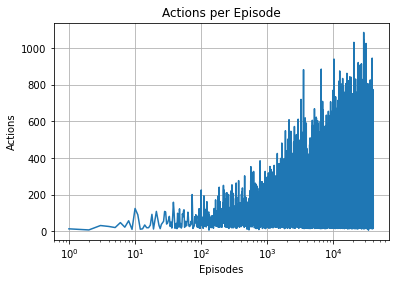

In [24]:
episodes = [i for i in range(1,k+1)]
plotGraph(episodes,agente.actions,"Actions per Episode","Episodes","Actions")

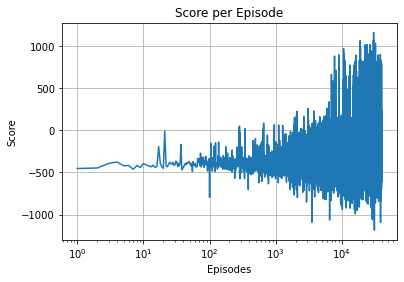

In [25]:
plotGraph(episodes,agente.scores,"Score per Episode","Episodes","Score")

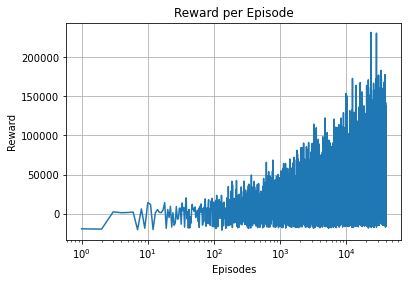

In [26]:
plotGraph(episodes,agente.rewards,"Reward per Episode","Episodes","Reward")  

In [6]:
argsM = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","mediumClassic"])

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'mediumClassic']


In [7]:
aM = []

In [8]:
agenteM = Qlearn(0.85,0.5,epsilon = 1)
argsM["pacman"] = agenteM

In [9]:
victorysM = []
kM = 40000
summM = 0
for i in range(kM):
    agenteM.setEpsilon(1/(i+1))
    aM.append(runGames(**argsM))
    if aM[i][0].state.isLose():
        agenteM.lose(aM[i][0])
    elif aM[i][0].state.isWin():
        agenteM.win(aM[i][0])
        victorysM.append(aM[i])
        print(i)
    summM += aM[i][0].state.getScore()

In [10]:
agenteM.serialize("../../notebooks/results/medium/a085-g05-d110721.json")

In [ ]:
showResults(agenteM,kM)

In [11]:
print(len(victorysM))
print(summM/kM)

0
-387.8459


In [ ]:
agente.printResult(kM)

In [9]:
argsO = readCommand(["-q", "--pacman", "LeftTurnAgent","--layout","originalClassic"])

['-q', '--pacman', 'LeftTurnAgent', '--layout', 'originalClassic']


In [10]:
aO = []

In [11]:
agenteO = Qlearn(0.85,0.5,epsilon = 1)
argsO["pacman"] = agenteO

In [ ]:
victorysO = []
kO = 40000
summO = 0
for i in range(kO):
    agenteO.setEpsilon(1/(i+1))
    aO.append(runGames(**argsO))
    if aO[i][0].state.isLose():
        agenteO.lose(aO[i][0])
    elif aO[i][0].state.isWin():
        agenteO.win(aO[i][0])
        victorysO.append(aO[i])
        print(i)
    summO += aO[i][0].state.getScore()

In [ ]:
agenteO.serialize("../../notebooks/results/original/a085-g05-d110721.json")

In [ ]:
showResults(agenteO,kO)

In [ ]:
print(len(victorysO))
print(summO/kO)

In [ ]:
agente.printResult(kM)

In [12]:
class smartPacman(Agent):
    def __init__(self, path):
        self.desserialize(path)
        self.score = 0
        self.action = 0
        self.scores = []
        self.actions = []
        self.win = 0
    
    def getQvalue(self,state,action):
        pair = str((state,action))
        return self.Qtable.get(pair,0.0)
    
    def getAction(self, state):
        actions = state.getLegalPacmanActions()
        currentState = getState(state)
        action = self.getBestAction(currentState,actions)
        return action
    
    def getBestAction(self,currentState,actions):
        maxValue = float("-inf")
        maxAction = []
        for i in actions:
            value = self.getQvalue(currentState,i)
            if value > maxValue:
                maxValue = value
                maxAction = [i]
            if value == maxValue:
                maxAction.append(i)
        #print(maxValue)
        #print(maxAction)
        self.action += 1
        return random.choice(maxAction)
    
    def desserialize(self,path):
        try:
            f = open(path,"r")
            self.Qtable = json.load(f)
            f.close()
        except:
            raise Exception("You've got an error")
    def finish(self,state,episode):
        if state.isWin():
            self.win +=1
        self.score = state.getScore()
        print("Episode: "+str(episode)+"; Score = "+str(self.score)+"; Actions = "+str(self.action))
        self.scores.append(self.score)
        self.actions.append(self.actions)
        self.action = 0
    
    def printResult(self,k):
        episodes = [i for i in range(1,k+1)]
        plotGraph(episodes,self.actions,"Actions per Episode","Episodes","Actions")
        plotGraph(episodes,self.scores,"Score per Episode","Episodes","Score")
    
    def winRate(self,k):
        summ = 0
        for i in self.scores:
            summ += i
        scoreAverage = summ/k
        winRate = (self.win/k) * 100
        print("Score average = "+ str(scoreAverage))
        print("Rate of wins = "+ str(winRate)+"%")

In [13]:
#best: agenteEsperto = smartPacman("../../notebooks/results/small/a085-g03-d100721-2.json")
agenteEsperto = smartPacman("../../notebooks/results/medium/a085-g05-d110721.json")
argsV = readCommand(["--pacman", "LeftTurnAgent","--layout","mediumClassic"])
argsV["pacman"] = agenteEsperto

['--pacman', 'LeftTurnAgent', '--layout', 'mediumClassic']


In [14]:
a = runGames(**argsV)
print(a[0].state.isWin())
print(a[0].state.getScore())

False
-442.0


In [ ]:
agenteEspertoS = smartPacman("../../notebooks/results/medium/a085-g05-d110721.json")
argsVS = readCommand(["q","--pacman", "LeftTurnAgent","--layout","smallClassic"])
argsVS["pacman"] = agenteEspertoS

In [ ]:
bS = []
kP = 10
for i in range(kP):
    bS.append(runGames(**argsVS))
    print(bS[i][0].state.isWin())
    print(bS[i][0].state.getScore())
    agenteEspertoS.finish(bS[i][0].state,i+1)

In [ ]:
agenteEspertoS.printResult(kP)
agenteEspertoS.winRate(kP)

In [ ]:
agenteEspertoM = smartPacman("../../notebooks/results/medium/a085-g05-d110721.json")
argsVM = readCommand(["q","--pacman", "LeftTurnAgent","--layout","mediumClassic"])
argsVM["pacman"] = agenteEspertoM

In [ ]:
bM = []
kM = 10
for i in range(kM):
    bM.append(runGames(**argsVM))
    print(bM[i][0].state.isWin())
    print(bM[i][0].state.getScore())
    agenteEspertoM.finish(bM[i][0].state,i+1)

In [ ]:
agenteEspertoM.printResult(kM)
agenteEspertoM.winRate(kM)

In [ ]:
agenteEspertoO = smartPacman("../../notebooks/results/medium/a085-g05-d110721.json")
argsVO = readCommand(["q","--pacman", "LeftTurnAgent","--layout","originalClassic"])
argsVO["pacman"] = agenteEspertoO

In [ ]:
bO = []
kO = 10
for i in range(kO):
    bO.append(runGames(**argsVO))
    print(bO[i][0].state.isWin())
    print(bO[i][0].state.getScore())
    agenteEspertoO.finish(bO[i][0].state,i+1)

In [ ]:
agenteEspertoO.printResult(kO)
agenteEspertoO.winRate(kO)